## Description

### This file is used for spliting the dataset, and it will consist of the following subset:
- image
  - {frame_id}.png &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Rendered image of a face
- label
  - {frame_id}\_seg.png &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Segmentation image, where each pixel has an integer value mapping to the categories below
- ldmks
  - {frame_id}\_ldmks.txt &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Landmark annotations for 70 facial landmarks (x, y) coordinates for every row

In [10]:
import os
import cv2
import shutil
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Define the dataset path and target folder
ROOT_PATH = 'H:/dataset_synthetic'
DATASET_NAME ='dataset_100'# choose the dataset 
DATASET_PATH = os.path.join(ROOT_PATH, DATASET_NAME)
IMAGE_FOLDER = os.path.join(DATASET_PATH, 'image')
LABEL_FOLDER = os.path.join(DATASET_PATH, 'label')
LDMKS_FOLDER = os.path.join(DATASET_PATH, 'ldmks')

In [22]:
# If the destination folder does not exist, create it
os.makedirs(IMAGE_FOLDER, exist_ok=True)
os.makedirs(LABEL_FOLDER, exist_ok=True)
os.makedirs(LDMKS_FOLDER, exist_ok=True)

In [24]:
# Traverse all files in the dataset folder
for filename in os.listdir(DATASET_PATH):
    file_path = os.path.join(DATASET_PATH, filename)
    
    # Check if it is a file (ignore folders)
    if os.path.isfile(file_path):
        # If the file name matches the image file format
        if filename.endswith('.png')and not filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(IMAGE_FOLDER, filename))
        
        # If the file name matches the mask file format
        elif filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(LABEL_FOLDER, filename))
            
        # If the file name matches the ldmks file formaty
        elif filename.endswith('_ldmks.txt'):
            shutil.move(file_path, os.path.join(LDMKS_FOLDER, filename))

###  Analyze the class distribution in the mask image and takes one image as an example :

In [27]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [29]:
image_id = '000000'
image_name = image_id + ".png"
mask_name = image_id + "_seg.png"
image_path = os.path.join(IMAGE_FOLDER, image_name)
mask_path = os.path.join(LABEL_FOLDER, mask_name)

In [31]:
# show a image-mask pairs
def showImg(image_path, mask_path):
    img = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
    print("img_size:", img.shape[:2] )
    print("mask_size:", mask.shape[:2] )
    mask = np.stack((mask,)*3, axis=-1)
    mid = np.zeros((IMG_HEIGHT, 50, 3))
    tmp = np.concatenate((img, mid), axis = 1)
    show_img = np.concatenate((tmp, mask), axis = 1)
    show_img = show_img.astype(np.uint8)
    plt.imshow(show_img)
    plt.show()

img_size: (512, 512)
mask_size: (512, 512)


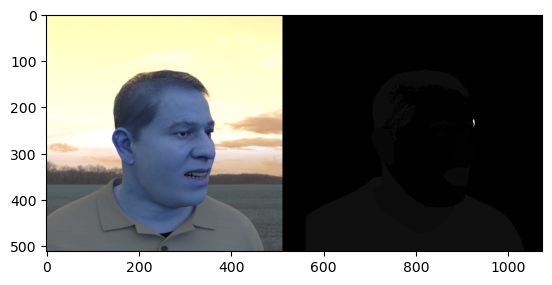

In [33]:
showImg(image_path, mask_path)

In [35]:
# Open the mask image and convert it into an numpy array
mask_example = Image.open(mask_path)
mask_array = np.array(mask_example)

In [37]:
# Print all unique values (category labels) # class RIGHT_EAR = 7,here doesn't show 
print("class label: ", np.unique(mask_array))

class label:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  15 255]


In [39]:
# Count the number of pixels for each label
unique, counts = np.unique(mask_array, return_counts=True)
label_counts = dict(zip(unique, counts))
print("The number of pixels per class:", label_counts) 

The number of pixels per class: {0: 157627, 1: 34444, 2: 2360, 3: 72, 4: 143, 5: 138, 6: 362, 8: 2799, 9: 552, 10: 473, 11: 713, 12: 10396, 13: 10374, 15: 41657, 255: 34}


## Check if there are images including incorrect label

In [42]:
image_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(LABEL_FOLDER) if f.endswith('.png')])

In [44]:
#Store the image file name with incorrect label
mislabeled_files = []

valid_categories = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 255]

for image_file, mask_file in zip(image_files, mask_files):
    # Check if the filename matches
    if image_file.split('.')[0] != mask_file.split('_seg')[0]:
        mislabeled_files.append(image_file)
        continue
    
   
    image = Image.open(os.path.join(IMAGE_FOLDER, image_file))
    mask = Image.open(os.path.join(LABEL_FOLDER, mask_file))

    # Check if the image and mask sizes match
    if image.size != mask.size:
        mislabeled_files.append(image_file)
        continue
    
    # Check if the mask contains only value 0 and 1
    mask_array = np.array(mask)
    unique_labels = np.unique(mask_array)  
    if not np.all(np.isin(unique_labels, valid_categories)):  
        #mislabeled_files.append(image_file)
        continue
        
if mislabeled_files: 
    output_filename = "mislabeled_files.txt"
    output_path = os.path.join(DATASET_PATH, output_filename)
    with open(output_path, 'w') as f:
        for file in mislabeled_files:
            f.write(f"{file}\n")
else:
    print("all labels are correct")
        

all labels are correct


## Prepare training set, validation set and test set

In [49]:
from sklearn.model_selection import train_test_split

# Dataset path
images_dir = os.path.join(DATASET_PATH, 'image')
labels_dir = os.path.join(DATASET_PATH, 'label')

# Output path
train_images_dir = os.path.join(DATASET_PATH, 'train/images')
train_labels_dir = os.path.join(DATASET_PATH, 'train/labels')
val_images_dir = os.path.join(DATASET_PATH, 'val/images')
val_labels_dir = os.path.join(DATASET_PATH, 'val/labels')
test_images_dir = os.path.join(DATASET_PATH, 'test/images')
test_labels_dir = os.path.join(DATASET_PATH, 'test/labels')

# Create folders
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Get file_names
image_ = sorted(os.listdir(images_dir))
label_ = sorted(os.listdir(labels_dir))


assert len(image_) == len(label_)

# Split the datasset train:val:test = 6:2:2 randomly
train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(image_, label_, test_size=0.4, random_state=42)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.5, random_state=42)

#Copy files to the destination folder
def copy_files(file_list, src_dir, dest_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(dest_dir, file_name))


copy_files(train_imgs, images_dir, train_images_dir)
copy_files(train_lbls, labels_dir, train_labels_dir)


copy_files(val_imgs, images_dir, val_images_dir)
copy_files(val_lbls, labels_dir, val_labels_dir)


copy_files(test_imgs, images_dir, test_images_dir)
copy_files(test_lbls, labels_dir, test_labels_dir)

In [71]:
# Output structure and size of each folder

def print_directory_structure(base_dir):
    dataset_types = ['train', 'val', 'test']
    structure = {}

    for dataset in dataset_types:
        images_dir = os.path.join(base_dir, dataset, 'images')
        labels_dir = os.path.join(base_dir, dataset, 'labels')
        
       
        num_images = len(os.listdir(images_dir))
        num_labels = len(os.listdir(labels_dir))
        
        structure[dataset] = {
            'images': num_images,
            'labels': num_labels
        }
    
    print("The structure and size of each folder：")
    for dataset in structure:
        print(f"{dataset.capitalize()}/")
        print(f"  ├── images/  ({structure[dataset]['images']} files)")
        print(f"  └── labels/  ({structure[dataset]['labels']} files)")
        print()

print_directory_structure(DATASET_PATH)        

The structure and size of each folder：
Train/
  ├── images/  (60 files)
  └── labels/  (60 files)

Val/
  ├── images/  (20 files)
  └── labels/  (20 files)

Test/
  ├── images/  (20 files)
  └── labels/  (20 files)

